In [28]:
import time
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import yfinance as yf
import datetime
from statsmodels.tsa.stattools import grangercausalitytests
import os

In [8]:
general_stocks = ['KO', 'PFE', 'WMT', 'PG', 'JNJ', 'DIS', 'PEP', 'MCD', 'T', 'VZ']
tech_stocks = ['AAPL', 'AMZN', 'MSFT', 'GOOGL', 'NVDA', 'TSLA', 'META', 'INTC', 'IBM', 'AMD']
finance_stocks = ['GS', 'BAC', 'WFC', 'USB', 'JPM', 'MA', 'V', 'AXP', 'C', 'BLK']
decentralized_currencies = ['BTC', 'ETH', 'ADA', 'BNB', 'SOL', 'XRP', 'DOGE', 'XMR', 'LTC', 'SHIB']

general_stocks_names = ['Coca-Cola', 'Pfizer', 'Walmart', 'Procter & Gamble', 'Johnson & Johnson', 'Disney', 'Pepsi', 'McDonalds', 'AT&T', 'Verizon']
tech_stocks_names = ['Apple', 'Amazon', 'Microsoft', 'Google', 'Nvidia', 'Tesla', 'Meta', 'Intel', 'IBM', 'AMD']
finance_stocks_names = ['Goldman Sachs', 'Bank of America', 'Wells Fargo', 'US Bancorp', 'JPMorgan Chase', 'Mastercard', 'Visa', 'American Express', 'Citigroup', 'BlackRock']
decentralized_currencies_names = ['Bitcoin', 'Ethereum', 'Cardano', 'Binance Coin', 'Solana', 'Ripple', 'Dogecoin', 'Monero', 'Litecoin', 'Shiba Inu']

color_map = {
    'general': 'deepskyblue',
    'tech': 'limegreen',
    'finance': 'darkorchid',
    'crypto': 'red'
}

In [9]:
def get_trends_data(keyword, 
                    timeframe=datetime.date.today().strftime('%Y-%m-%d') + ' ' + (datetime.date.today() - datetime.timedelta(days = 269)).strftime('%Y-%m-%d'),
                    retries=5, 
                    backoff_factor=1.0):
    pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25), )
    pytrends.build_payload(keyword, cat = 0, timeframe = timeframe, geo='')
    
    for i in range(retries):
        try:
            df = pytrends.interest_over_time()
            if df is not None and not df.empty:
                print(f"Trend Data for {keyword} retrieved successfully.")
                df.reset_index(inplace = True)
                df.rename(columns = {'date': 'Date', keyword[0]: 'Trend'}, inplace = True)
                df['Date'] = pd.to_datetime(df['Date'].dt.strftime('%m/%d/%Y'))
                return df
            else:
                print("No data retrieved or DataFrame is empty.")
                return None
        except Exception as e:
            if "429" in str(e):
                sleep_time = backoff_factor * (2 ** i)
                print(f"Rate limit exceeded. Retrying in {sleep_time} seconds...")
                time.sleep(sleep_time)
            else:
                raise(f"An error occurred: {e}")
    print("Failed to retrieve data after several retries.")
    return None

In [10]:
def get_stock_data(ticker, start, end):
    currTicker = yf.Ticker(ticker)
    tickerDF = currTicker.history(repair = True, start = start, end = end, auto_adjust = False).drop(columns = ['Dividends', 'Stock Splits', 'Repaired?']).reset_index()
    print(f"Stock Data for {ticker} retrieved successfully.")
    tickerDF['Date'] = pd.to_datetime(tickerDF['Date'].dt.strftime('%m/%d/%Y'))
    return tickerDF

In [11]:
def trend_corr(stock, days = 60, start = '2023-10-01', end = '2024-06-01', delay = 7):
    if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
        if stock in general_stocks:
            name = general_stocks_names[general_stocks.index(stock)]
        elif stock in tech_stocks:
            name = tech_stocks_names[tech_stocks.index(stock)]
        elif stock in finance_stocks:
            name = finance_stocks_names[finance_stocks.index(stock)]
        else:
            name = decentralized_currencies_names[decentralized_currencies.index(stock)]
        t = get_trends_data([name], timeframe = f"{start} {end}")
        if t is None:
            raise Exception(f'Failed to retrieve Trend Data of {stock}.')
        t.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    if not os.path.exists(f"./Data/{stock}_Prices({start} - {end}).csv"):
        if stock in decentralized_currencies:
            p = get_stock_data(f'{stock}-USD', start = start, end = end)
        else:
            p = get_stock_data(stock, start = start, end = end)
        p.to_csv(f"./Data/{stock}_Prices({start} - {end}).csv")
    else:
        p = pd.read_csv(f"./Data/{stock}_Prices({start} - {end}).csv")

    t['Date'] = pd.to_datetime(t['Date'])
    p['Date'] = pd.to_datetime(p['Date'])

    full_data = pd.merge(p, t, on='Date')

    full_data['log_returns'] = np.log(full_data.Close / full_data.Close.shift(1))
    full_data['Volatility'] = full_data['log_returns'].rolling(window=days).std() * np.sqrt(days)

    for i in range(1, 8):
        full_data[f'Delay_{i}'] = full_data['Trend'].shift(i)

    rho = full_data.corr()
    rho_c = rho['Close'][f'Delay_{delay}']
    return rho_c, full_data

In [12]:
def plot_stock_data(stock, days = 60, start = '2023-10-01', end = '2024-06-01', delay = 7, download = False):
    if not os.path.exists(f"./Data/{stock}_trends({start} - {end}).csv"):
        if stock in general_stocks:
            name = general_stocks_names[general_stocks.index(stock)]
        elif stock in tech_stocks:
            name = tech_stocks_names[tech_stocks.index(stock)]
        elif stock in finance_stocks:
            name = finance_stocks_names[finance_stocks.index(stock)]
        else:
            name = decentralized_currencies_names[decentralized_currencies.index(stock)]
        t = get_trends_data([name], timeframe = f"{start} {end}")
        t.to_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({start} - {end}).csv")
    if not os.path.exists(f"./Data/{stock}_Prices({start} - {end}).csv"):
        p = get_stock_data(stock, start = start, end = end)
        p.to_csv(f"./Data/{stock}_Prices({start} - {end}).csv")
    else:
        p = pd.read_csv(f"./Data/{stock}_Prices({start} - {end}).csv")

    t['Date'] = pd.to_datetime(t['Date'])
    p['Date'] = pd.to_datetime(p['Date'])

    full_data = pd.merge(p, t, on='Date')

    full_data['log_returns'] = np.log(full_data.Close / full_data.Close.shift(1))
    full_data['Volatility'] = full_data['log_returns'].rolling(window=days).std() * np.sqrt(days)

    full_data[f'Delay_{delay}'] = full_data.Trend.shift(7)

    # Determine the color based on the stock category
    if stock in general_stocks:
        color = color_map['general']
        name = general_stocks_names[general_stocks.index(stock)]
    elif stock in tech_stocks:
        color = color_map['tech']
        name = tech_stocks_names[tech_stocks.index(stock)]
    elif stock in finance_stocks:
        color = color_map['finance']
        name = finance_stocks_names[finance_stocks.index(stock)]
    else:
        color = color_map['crypto']
        name = decentralized_currencies_names[decentralized_currencies.index(stock)]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Plot Close price
    axes[0].plot(full_data['Date'], full_data['Close'], label = 'Close Price', color = color)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Close Price')
    axes[0].set_title(f'{stock}: Close Price')
    legend = axes[0].legend(loc='upper left')
    legend.get_frame().set_alpha(0.3)

    # Plot 7-days delay trend
    axes[1].plot(full_data['Date'], full_data[f'Delay_{delay}'], label = f'{delay}-Days Delayed Trend', color = 'black')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel(f'{delay}-Days Delayed Trend')
    axes[1].set_title(f'{stock}: {delay}-Days Delayed Trend')
    legend = axes[1].legend(loc='upper right')
    legend.get_frame().set_alpha(0.3)

    fig.suptitle(f'{name} ({stock})', fontsize=20, verticalalignment = 'bottom', fontweight = 'bold')
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(top=0.95)
    if download:
        plt.savefig(f"./Plots/{stock}_plot({start} - {end}).png", bbox_inches='tight')
    plt.show()

In [63]:
# function to find the date in string format after a certain number of days
def time_jump(start, days = 7 * 38):
    return (datetime.datetime.strptime(start, '%Y-%m-%d') + datetime.timedelta(days = days)).strftime('%Y-%m-%d')

In [64]:
def get_breakpoints(start, end, days = 7 * 38):
    breakpoints = [start]
    while datetime.datetime.strptime(breakpoints[-1], '%Y-%m-%d') < datetime.datetime.strptime(end, '%Y-%m-%d'):
        temp = time_jump(breakpoints[-1], days)
        if datetime.datetime.strptime(temp, '%Y-%m-%d') < datetime.datetime.strptime(end, '%Y-%m-%d'):
            breakpoints.append(temp)
        else:
            breakpoints.append(end)
    return breakpoints

In [44]:
def connectNnormalizeTrends(Dfs, stock):
    # setting up the data for step 1
    glmpsDf = pd.read_csv(f'Data/glimpse_{stock}_5Y.csv')
    glmpsDf.rename(columns={'Time (week of)': 'Date', 'Absolute Google Search Volume': 'Absolute_Volume'}, inplace=True)
    glmpsDf['Date'] = pd.to_datetime(glmpsDf['Date'])

    df_concat = pd.concat(Dfs).reset_index(drop = True)
    df_concat['Date'] = pd.to_datetime(df_concat['Date'])

    # calculating the mean trend for each week and merging it into glmpsDf
    df_concat['MeanTrend'] = df_concat['Trend'].rolling(window=7, min_periods=1).mean().shift(-6)
    glmpsDf = pd.merge(glmpsDf, df_concat, on='Date', how='left').drop(columns = ['Trend'])

    # setting up the data for step 2
    glmpsDf.rename(columns={'Date': 'Date_Week'}, inplace=True)
    df_concat = df_concat.drop(columns = ['MeanTrend'])
    df_concat['Date_Week'] = (df_concat['Date'] - pd.to_timedelta((df_concat['Date'].dt.weekday + 1) % 7, unit='d')).dt.strftime('%Y-%m-%d')
    df_concat['Date_Week'] = pd.to_datetime(df_concat['Date_Week'])

    # calculating the ratio and search volume for each week
    df_concat = pd.merge(df_concat, glmpsDf[['Date_Week', 'MeanTrend', 'Absolute_Volume']], on='Date_Week', how='left')
    df_concat['Ratio'] = df_concat['Trend'] / (df_concat['MeanTrend'] * 7)
    df_concat['Search_Volume'] = df_concat['Ratio'] * df_concat['Absolute_Volume']

    # adding to df_concat the check ratio to check validity of the data
    df_concat['check_ratio'] = df_concat['Search_Volume'] / df_concat['Trend']

    # renormalizing the data
    df_concat['Normalized_Searches'] = ((df_concat['Search_Volume'] - df_concat['Search_Volume'].min()) / (df_concat['Search_Volume'].max() - df_concat['Search_Volume'].min())) * 100

    # cleaning out unnecessary columns
    df_concat = df_concat.drop(columns = ['Trend', 'Date_Week', 'MeanTrend', 'Absolute_Volume', 'Ratio'])

    df_concat['Date'] = df_concat['Date'].dt.strftime('%Y-%m-%d')

    return df_concat

$$Normalized\;Value=\frac{search\;value\;for\;term}{total\;Search\;Volume} * 100$$

and then each one devided by the max

In [51]:
list1 = [1, 2, 3, 4, 5]
list2 = [3, 4, 5, 6, 7]

list1 = [x for x in list1 if x not in list2]

print(list1)

['2020-03-16',
 '2020-12-08',
 '2021-09-01',
 '2022-05-26',
 '2023-02-17',
 '2023-11-11']

In [72]:
# setting up the the dates for data extraction
start = '2019-06-23'
end = '2024-06-30'
breakpoints = get_breakpoints(start, end)
breakpoints2 = get_breakpoints(start, end, days = 7 * 19)
breakpoints2 = [x for x in breakpoints2 if x not in breakpoints[1:-1]]
stock = 'Bitcoin'
ticker = 'BTC'

# initializing the list to store the dataframes
bitcoinDFs = []

# extracting the data for each time period
for i in range(len(breakpoints) - 1):
    startTemp = breakpoints[i]
    endTemp = time_jump(breakpoints[i + 1], days=-1)
    # checking if the data is already extracted
    if not os.path.exists(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv"):
        # extracting the data
        t = get_trends_data([stock], timeframe = f"{startTemp} {endTemp}").drop(columns = ['isPartial'])
        if t is None:
            raise Exception(f'Failed to retrieve Trend Data of {stock}.')
        t.to_csv(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv").drop(columns = ['Unnamed: 0'])

    bitcoinDFs.append(t)

# initializing the list to store the dataframes
bitcoinDFs2 = []

# extracting the data for each time period
for i in range(len(breakpoints2) - 1):
    startTemp = breakpoints2[i]
    endTemp = time_jump(breakpoints2[i + 1], days=-1)
    # checking if the data is already extracted
    if not os.path.exists(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv"):
        # extracting the data
        t = get_trends_data([stock], timeframe = f"{startTemp} {endTemp}").drop(columns = ['isPartial'])
        if t is None:
            raise Exception(f'Failed to retrieve Trend Data of {stock}.')
        t.to_csv(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv")
    else:
        t = pd.read_csv(f"./Data/{stock}_trends({startTemp} - {endTemp}).csv").drop(columns = ['Unnamed: 0'])

    bitcoinDFs2.append(t)

bitcoin_concat = connectNnormalizeTrends(bitcoinDFs, stock)
bitcoin_concat2 = connectNnormalizeTrends(bitcoinDFs2, stock)

bitcoin_concat["Normalized_Searches"] = (bitcoin_concat["Normalized_Searches"] + bitcoin_concat2["Normalized_Searches"]) / 2

if not os.path.exists(f"./Data/{stock}_Prices({start}-{end}).csv"):
    bitcoin_stock = get_stock_data(f'{ticker}-USD', start = start, end = end)
    bitcoin_stock.to_csv(f"./Data/{stock}_Prices({start}-{end}).csv")
else:
    bitcoin_stock = pd.read_csv(f"./Data/{stock}_Prices({start}-{end}).csv").drop(columns = ['Unnamed: 0'])

bitcoin_stock['log_returns'] = np.log(bitcoin_stock.Close / bitcoin_stock.Close.shift(1))

bitcoin_data = pd.merge(bitcoin_stock, bitcoin_concat, on='Date', how='left')

bitcoin_data = bitcoin_data.dropna()

C:\Users\tomge\AppData\Local\Temp\ipykernel_23968\2735589715.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  glmpsDf['Date'] = pd.to_datetime(glmpsDf['Date'])
C:\Users\tomge\AppData\Local\Temp\ipykernel_23968\2735589715.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  glmpsDf['Date'] = pd.to_datetime(glmpsDf['Date'])


In [ ]:
# checking validity of the data
top = 0
bottom = 0
for i in range(len(bitcoinDFs)):
    top += bitcoinDFs[i].shape[0]
    print(f'period {i + 1}:\n=========\nmean: {bitcoin_concat.iloc[bottom:top]['check_ratio'].mean():.4f}\nsd: {bitcoin_concat.iloc[bottom:top]["check_ratio"].std():.4f}\n\nmean/sd: {bitcoin_concat.iloc[bottom:top]['check_ratio'].mean()/bitcoin_concat.iloc[bottom:top]["check_ratio"].std():.4f}\n')
    bottom += bitcoinDFs[i].shape[0]

top = 0
bottom = 0
for i in range(len(bitcoinDFs2)):
    top += bitcoinDFs2[i].shape[0]
    print(f'period {i + 1}:\n=========\nmean: {bitcoin_concat.iloc[bottom:top]['check_ratio'].mean():.4f}\nsd: {bitcoin_concat.iloc[bottom:top]["check_ratio"].std():.4f}\n\nmean/sd: {bitcoin_concat.iloc[bottom:top]['check_ratio'].mean()/bitcoin_concat.iloc[bottom:top]["check_ratio"].std():.4f}\n')
    bottom += bitcoinDFs2[i].shape[0]

In [74]:
max_lags = 30  # Maximum number of lags to test for
test_result = grangercausalitytests(x = bitcoin_data[['log_returns', 'Normalized_Searches']], 
                                    maxlag = max_lags,
                                    verbose = True)

d:\pyVers\py3.12.2\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0026  , p=0.9590  , df_denom=1829, df_num=1
ssr based chi2 test:   chi2=0.0027  , p=0.9589  , df=1
likelihood ratio test: chi2=0.0027  , p=0.9589  , df=1
parameter F test:         F=0.0026  , p=0.9590  , df_denom=1829, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4847  , p=0.2268  , df_denom=1826, df_num=2
ssr based chi2 test:   chi2=2.9775  , p=0.2257  , df=2
likelihood ratio test: chi2=2.9751  , p=0.2259  , df=2
parameter F test:         F=1.4847  , p=0.2268  , df_denom=1826, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9483  , p=0.4164  , df_denom=1823, df_num=3
ssr based chi2 test:   chi2=2.8558  , p=0.4144  , df=3
likelihood ratio test: chi2=2.8536  , p=0.4148  , df=3
parameter F test:         F=0.9483  , p=0.4164  , df_denom=1823, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0283  , p=0.

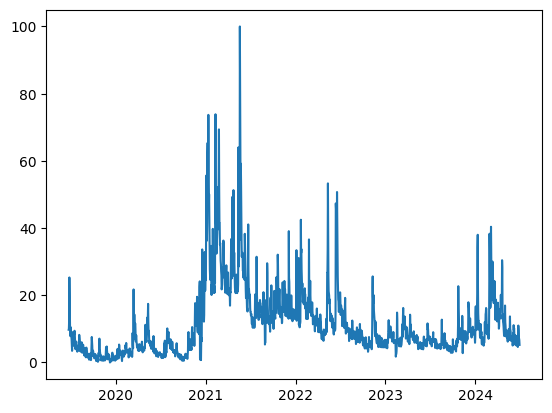

In [146]:
plt.plot(bitcoin_concat['Date'], bitcoin_concat['Normalized_Searches'])

כל מספר מתרגם לכמות מסויימת של חיפושים

להתאים בין כמות החיפושים באותו חודש למספר ולהבין כמה כל פיפס במנורמל מתרגם לכמות חיפושים

בודקים את היחס בין הכמות חיפושים לנרמול כפול כמות הנקודות

מגיעים למספר הממוצע של כל הנקודות בדאטא פריים הראשון

בכל שבוע יש ערך מנורמל וערך אבסולוטי ורוצים לראות בערך את אותו מספר בהתאם לחישוב היחסים

ווידוא שגלימפס עושים את העבודה כמו שצריך

לקחת את היחס בין חיפושים לקליקים ולראות אם הוא תואם בכל התקופה, בהתאם אפשר למצוא את הערכים לפי היחס

לוקחים את הגרף של החמש שנים היומי

כל נקודה מחסרים ממנה את המינימום של כל התקופה

ומחלקים במקסימום פחות המינימום כפול 100

********אולי לנסות אחר כך גם לפי שעתי או אפילו לפי דקה

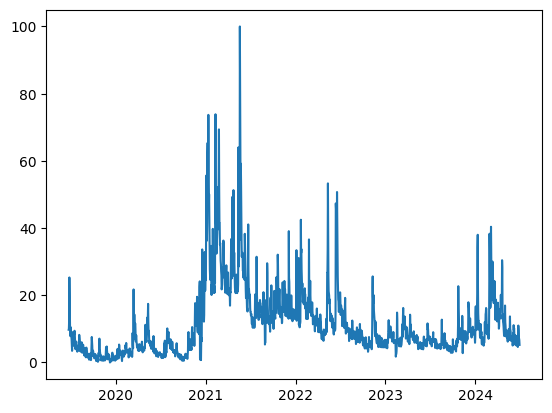

In [23]:
total1 = t1['Trend'].sum()
total2 = t2['Trend'].sum()

t1['Normalized'] = t1['Trend'] / total1 * 100
t2['Normalized'] = t2['Trend'] / total2 * 100

t1[]

# print(t1[t1['Date'] == '2023-10-03']['Trend'].values[0] / t2[t2['Date'] == '2023-10-03']['Trend'].values[0])
# print(t1[t1['Date'] == '2023-10-02']['Trend'].values[0] / t2[t2['Date'] == '2023-10-02']['Trend'].values[0])
# print(t1[t1['Date'] == '2023-10-01']['Trend'].values[0] / t2[t2['Date'] == '2023-10-01']['Trend'].values[0])

2.391304347826087
2.2222222222222223
2.3


In [4]:
# Calculate correlations for each category
volt_del_corr_general = [trend_corr(stock)[0] for stock in general_stocks]
volt_del_corr_tech = [trend_corr(stock)[0] for stock in tech_stocks]
volt_del_corr_finance = [trend_corr(stock)[0] for stock in finance_stocks]
volt_del_corr_crypto = [trend_corr(crypto)[0] for crypto in decentralized_currencies]

# Combine the results
volt_del_corr = volt_del_corr_general + volt_del_corr_tech + volt_del_corr_finance + volt_del_corr_crypto

# Create labels for the scatter plot
labels = general_stocks + tech_stocks + finance_stocks + decentralized_currencies

Trend Data for ['Shiba Inu'] retrieved successfully.
Stock Data for SHIB-USD retrieved successfully.


In [ ]:
# Plot the scatter plot
plt.figure(figsize=(16, 8))
plt.scatter(range(len(general_stocks)), volt_del_corr_general, color = color_map['general'], label = 'General Stocks')
for i in range(len(general_stocks)):
    plt.axvline(x = i, color = color_map['general'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks), len(general_stocks) + len(tech_stocks)), volt_del_corr_tech, color = color_map['tech'], label = 'Tech Stocks')
for i in range(len(general_stocks), len(general_stocks) + len(tech_stocks)):
    plt.axvline(x = i, color = color_map['tech'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks) + len(tech_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks)), volt_del_corr_finance, color = color_map['finance'], label = 'Finance Stocks')
for i in range(len(general_stocks) + len(tech_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks)):
    plt.axvline(x = i, color = color_map['finance'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.scatter(range(len(general_stocks) + len(tech_stocks) + len(finance_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks) + len(decentralized_currencies)), volt_del_corr_crypto, color = color_map['crypto'], label = 'Decentralized Currencies')
for i in range(len(general_stocks) + len(tech_stocks) + len(finance_stocks), len(general_stocks) + len(tech_stocks) + len(finance_stocks) + len(decentralized_currencies)):
    plt.axvline(x = i, color = color_map['crypto'], linestyle = ':', alpha = 0.3)  # Add vertical lines to separate the stocks
plt.axhline(y = 0, color = 'black', linestyle = '--')  # Add a horizontal line at y = 0
plt.xlabel('Assets')
plt.ylabel('Correlation with 7-Day Delayed Trend')
plt.title('Correlation of Close Price and 7-Day Delayed Trend')
legend = plt.legend()
legend.get_frame().set_alpha(0.3)
plt.xticks(range(len(labels)), labels, rotation = 60)
plt.tight_layout(pad = 2)
plt.savefig('Correlation_Scatter_Plot.png')
plt.show()

# Print the correlation values and their mean
print(volt_del_corr, np.mean(volt_del_corr))

In [ ]:
# Plot for each stock and decentralized currency
for stock in general_stocks + tech_stocks + finance_stocks + decentralized_currencies:
    plot_stock_data(stock, download = True)